In [4]:
# =========================
# 🚀 Imports and data load
# =========================
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load your prepared pickles
X_train = pd.read_pickle("3_Model/Neural_Net_Edilbek/pickle_data_2/training_features.pkl")
y_train = pd.read_pickle("3_Model/Neural_Net_Edilbek/pickle_data_2/training_labels.pkl")
X_valid = pd.read_pickle("3_Model/Neural_Net_Edilbek/pickle_data_2/validation_features.pkl")
y_valid = pd.read_pickle("3_Model/Neural_Net_Edilbek/pickle_data_2/validation_labels.pkl")
X_test = pd.read_pickle("3_Model/Neural_Net_Edilbek/pickle_data_2/test_features.pkl")
y_test = pd.read_pickle("3_Model/Neural_Net_Edilbek/pickle_data_2/test_labels.pkl")

# Ensure categorical columns are encoded numerically
for df in [X_train, X_valid, X_test]:
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype('category').cat.codes

X_train_np, y_train_np = X_train.to_numpy(dtype=np.float32), y_train.to_numpy(dtype=np.float32)
X_valid_np, y_valid_np = X_valid.to_numpy(dtype=np.float32), y_valid.to_numpy(dtype=np.float32)
X_test_np, y_test_np = X_test.to_numpy(dtype=np.float32), y_test.to_numpy(dtype=np.float32)


In [5]:
# =========================
# 🪄 Function to create window dataset
# =========================
def make_window_dataset(X, y, window_size=30, batch_size=32):
    if len(X) < window_size:
        print(f"⚠️ Not enough data points to create a window dataset. Needed: {window_size}, got: {len(X)}")
        return None
    return tf.keras.preprocessing.timeseries_dataset_from_array(
        data=X,
        targets=y[window_size-1:],
        sequence_length=window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=batch_size
    )


In [6]:
# =========================
# 🔍 Create datasets
# =========================
train_ds = make_window_dataset(X_train_np, y_train_np, 30, 32)
valid_ds = make_window_dataset(X_valid_np, y_valid_np, 30, 32)
test_ds = make_window_dataset(X_test_np, y_test_np, 30, 32)

# =========================
# 📊 Print summary of datasets
# =========================
print(f"{'DATASET':<10} | {'BATCHES':<7} | {'EXAMPLE SHAPE'}")
print("-" * 40)

for name, ds in [("Train", train_ds), ("Valid", valid_ds), ("Test", test_ds)]:
    if ds is None:
        print(f"{name:<10} | {'None':<7} | -")
    else:
        example_shape = next(iter(ds.take(1)))[0].shape
        print(f"{name:<10} | {len(ds):<7} | {example_shape}")


DATASET    | BATCHES | EXAMPLE SHAPE
----------------------------------------
Train      | 114     | (32, 30, 28)
Valid      | 55      | (32, 30, 28)
Test       | 53      | (32, 30, 28)


Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 64538.2812 - mae: 207.8798 - val_loss: 25124.9746 - val_mae: 107.0556
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42581.3477 - mae: 150.6184 - val_loss: 2050108.2500 - val_mae: 1425.7421
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22547.0684 - mae: 110.5731 - val_loss: 1946178.6250 - val_mae: 1388.9480
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21654.7637 - mae: 114.5396 - val_loss: 607209.6875 - val_mae: 768.9624
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20411.5898 - mae: 109.5597 - val_loss: 336429.0938 - val_mae: 566.7292
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16339.8096 - mae: 96.6770 - val_loss: 64798.6211 - val_mae: 235.1225
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14564.0068 - mae: 89.3753 - val_loss: 114651.2891 - val_mae: 324.0957
Epoch 8/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11865.0762 - mae: 78.39

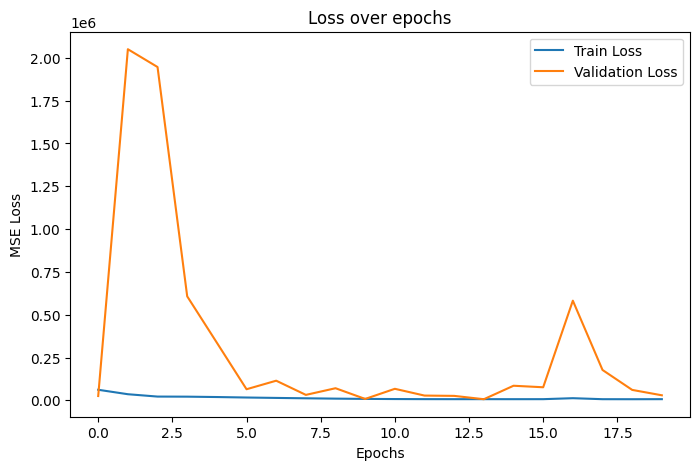

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33069.8125 - mae: 170.4258
✅ Test MSE: 32503.751953125
✅ Test MAE: 169.3048095703125


In [8]:
# =========================
# 🧠 Build & train model safely
# =========================
if train_ds is not None and valid_ds is not None:
    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(30, X_train.shape[1])),
    tf.keras.layers.GlobalAveragePooling1D(),  # replaces Flatten()
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse', metrics=['mae'])

    history = model.fit(
        train_ds,
        validation_data=valid_ds,
        epochs=20
    )

    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.show()

    # =========================
    # 🎯 Evaluate on test
    # =========================
    if test_ds is not None:
        test_loss, test_mae = model.evaluate(test_ds)
        print("✅ Test MSE:", test_loss)
        print("✅ Test MAE:", test_mae)
    else:
        print("⚠️ Test dataset is empty. Skipping test evaluation.")
else:
    print("⚠️ Not enough data to train the model.")


2025-07-01 00:42:07.597271: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


✅ Validation MAPE: 130.10%
✅ Test MAPE: 130.80%


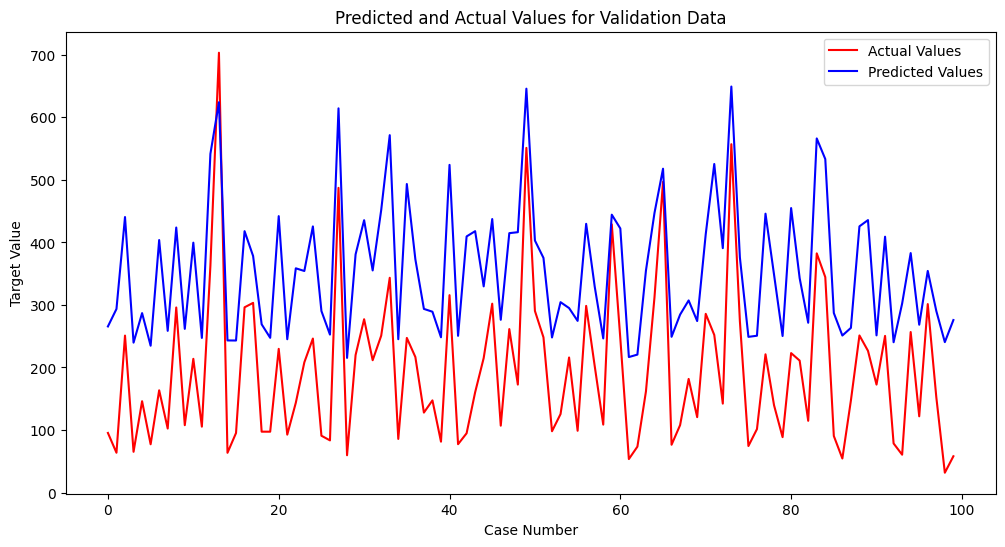

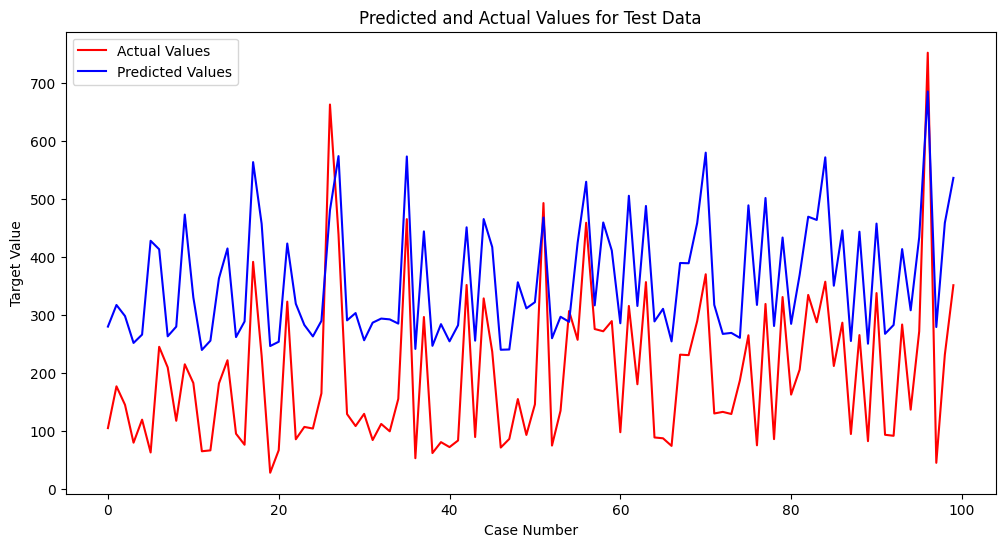

In [9]:
from sklearn.metrics import mean_absolute_percentage_error

def plot_predictions(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['actual'], label='Actual Values', color='red')
    plt.plot(data['prediction'], label='Predicted Values', color='blue')
    plt.title(title)
    plt.xlabel('Case Number')
    plt.ylabel('Target Value')
    plt.legend()
    plt.show()

# =====================
# 🔮 Make predictions
# =====================
def get_predictions_and_labels(dataset):
    predictions = []
    labels = []
    for x, y in dataset:
        preds = model.predict(x, verbose=0)
        predictions.extend(preds.flatten())
        labels.extend(y.numpy().flatten())
    return np.array(predictions), np.array(labels)

validation_predictions, validation_labels = get_predictions_and_labels(valid_ds)
test_predictions, test_labels = get_predictions_and_labels(test_ds)

# =====================
# 📊 MAPE in %
# =====================
mape_val = mean_absolute_percentage_error(validation_labels, validation_predictions) * 100
mape_test = mean_absolute_percentage_error(test_labels, test_predictions) * 100

print(f"✅ Validation MAPE: {mape_val:.2f}%")
print(f"✅ Test MAPE: {mape_test:.2f}%")

# =====================
# 📈 DataFrames + plots
# =====================
data_validation = pd.DataFrame({'prediction': validation_predictions, 'actual': validation_labels})
data_test = pd.DataFrame({'prediction': test_predictions, 'actual': test_labels})

plot_predictions(data_validation.head(100), 'Predicted and Actual Values for Validation Data')
plot_predictions(data_test.head(100), 'Predicted and Actual Values for Test Data')
